In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv("heart.csv")

df_num = df[['Age' , 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']]
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Inspect Data

In [3]:
pos_cases = df.HeartDisease.value_counts()
print(pos_cases)
print(f"Percentage of Positive Cases in Dataset: {(pos_cases.loc[1] / pos_cases.sum() * 100):.2f}%")

1    508
0    410
Name: HeartDisease, dtype: int64
Percentage of Positive Cases in Dataset: 55.34%


In [4]:
# no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.ChestPainType.value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [6]:
df.RestingECG.value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [7]:
df.ST_Slope.value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

# Categorical Variable Exploration

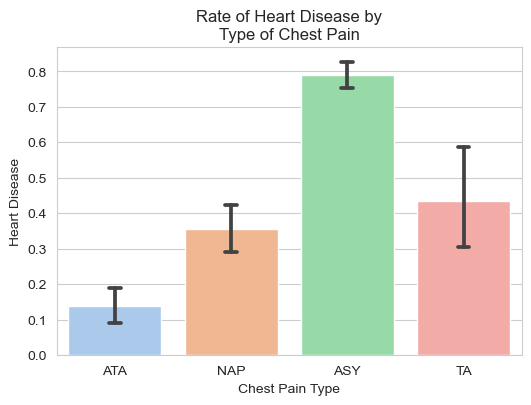

In [8]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'ChestPainType', y = 'HeartDisease', capsize = .1)
plt.title("Rate of Heart Disease by\nType of Chest Pain")
plt.xlabel("Chest Pain Type")
plt.ylabel("Heart Disease")
plt.show()

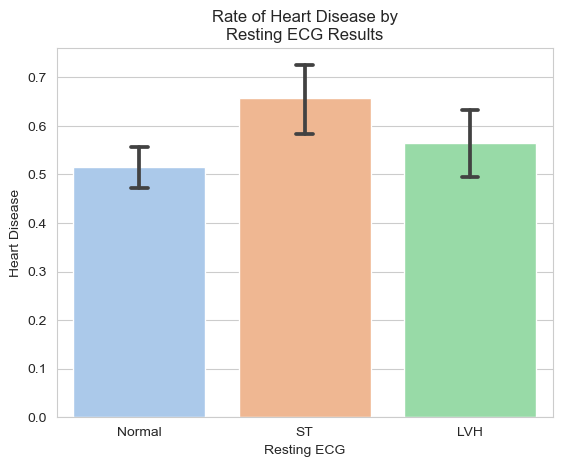

In [9]:
plt.figure()
sns.barplot(data = df, x = 'RestingECG', y = 'HeartDisease', capsize = .1)
plt.title("Rate of Heart Disease by\nResting ECG Results")
plt.xlabel("Resting ECG")
plt.ylabel("Heart Disease")
plt.show()

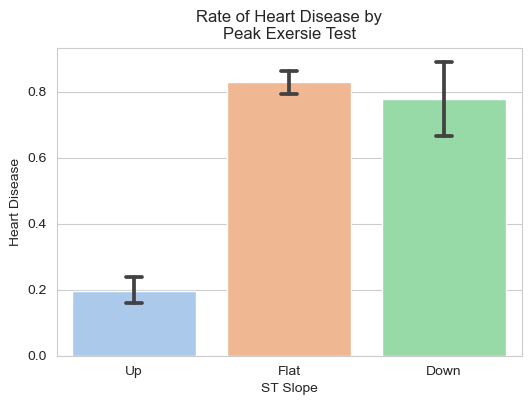

In [10]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'ST_Slope', y = 'HeartDisease', capsize = .1)
plt.title("Rate of Heart Disease by\nPeak Exersie Test")
plt.xlabel("ST Slope")
plt.ylabel("Heart Disease")
plt.show()

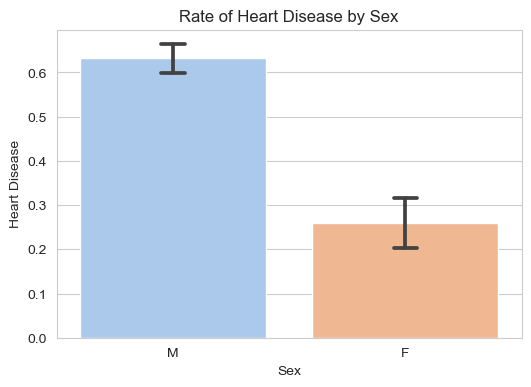

In [11]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'Sex', y = 'HeartDisease', capsize = .1)
plt.title("Rate of Heart Disease by Sex")
plt.xlabel("Sex")
plt.ylabel("Heart Disease")
plt.show()

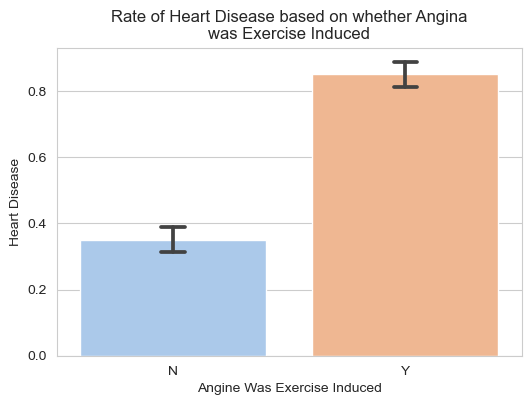

In [12]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'ExerciseAngina', y = 'HeartDisease', capsize = .1)
plt.title("Rate of Heart Disease based on whether Angina\nwas Exercise Induced")
plt.xlabel("Angine Was Exercise Induced")
plt.ylabel("Heart Disease")
plt.show()

# Categorical Exploration Results:

>The only categorical variable that does not seem to play a significant role in whether or not a patient develops heart disease is the "RestingECG" column.  Thus, we will include all categorical variables in our Machine Learning model with the exception of this one.

# Continous Variable Exploration

In [13]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

In [14]:
def generate_diffs_and_graph(col, len_a, df):
    # generated permuted differences
    actual_diff = group.loc[1][col] - group.loc[0][col]
    diffs = [perm_fun(df, col, len_a) for _ in range(1000)]
    
    # plot permuted differences and actual difference
    plt.figure(figsize = (5,4))
    sns.histplot(diffs)
    plt.axvline(x = actual_diff, color = 'red')
    plt.title(f"Perm Test (statistical significance) for {col}")
    plt.show()

    # calculate and print p-val for statistical significance test
    p_val = [np.abs(diff) > np.abs(actual_diff) for diff in diffs]
    p_val = np.array(p_val).mean()
    print("p-val:", p_val)
    
    return p_val

In [15]:
df_num.head(3)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,40,140,289,0,172,0.0,0
1,49,160,180,0,156,1.0,1
2,37,130,283,0,98,0.0,0


In [16]:
group = df_num.groupby('HeartDisease').mean()
group

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
HeartDisease,,,,,,
0,50.551220,130.180488,227.121951,0.107317,148.151220,0.408049
1,55.899606,134.185039,175.940945,0.334646,127.655512,1.274213


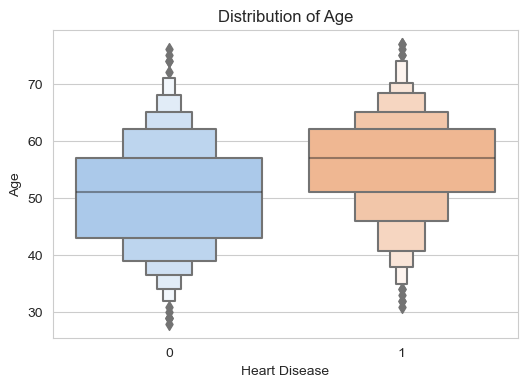

In [17]:
plt.figure(figsize = (6,4))
sns.boxenplot(data = df_num, x = 'HeartDisease', y = 'Age')
plt.title("Distribution of Age")
plt.xlabel("Heart Disease")
plt.show()

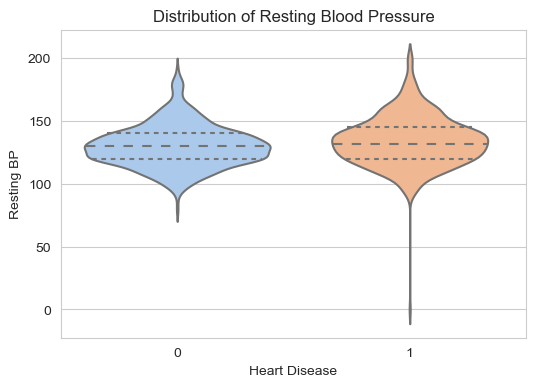

In [18]:
plt.figure(figsize = (6,4))
sns.violinplot(data = df_num, x = 'HeartDisease', y = 'RestingBP', inner = 'quartile')
plt.title("Distribution of Resting Blood Pressure")
plt.ylabel("Resting BP")
plt.xlabel("Heart Disease")
plt.show()

In [19]:
df_num.HeartDisease.value_counts().loc[1]

508

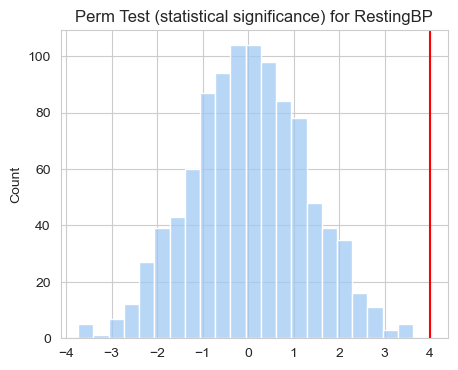

p-val: 0.0


0.0

In [20]:
pos_cases = df_num.HeartDisease.value_counts().loc[1]
generate_diffs_and_graph('RestingBP', pos_cases, df_num)

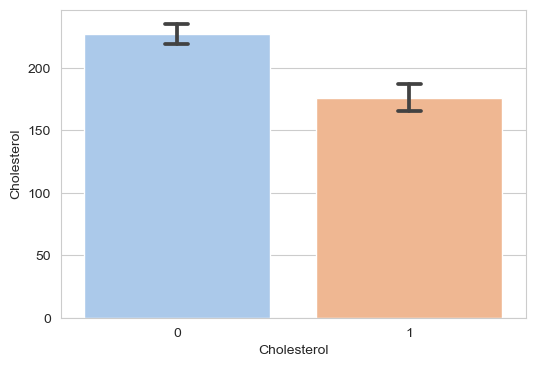

In [21]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_num, x = 'HeartDisease', y = 'Cholesterol', capsize = .1)
plt.xlabel("Cholesterol")
plt.show()

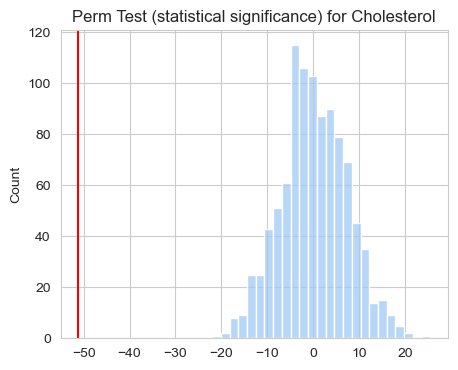

p-val: 0.0


0.0

In [22]:
generate_diffs_and_graph('Cholesterol', pos_cases, df_num)

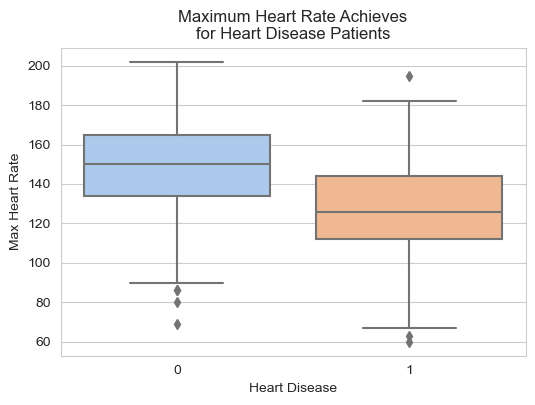

In [23]:
plt.figure(figsize = (6,4))
sns.boxplot(data = df_num, x = 'HeartDisease', y = 'MaxHR')
plt.title("Maximum Heart Rate Achieves\nfor Heart Disease Patients")
plt.ylabel("Max Heart Rate")
plt.xlabel("Heart Disease")
plt.show()

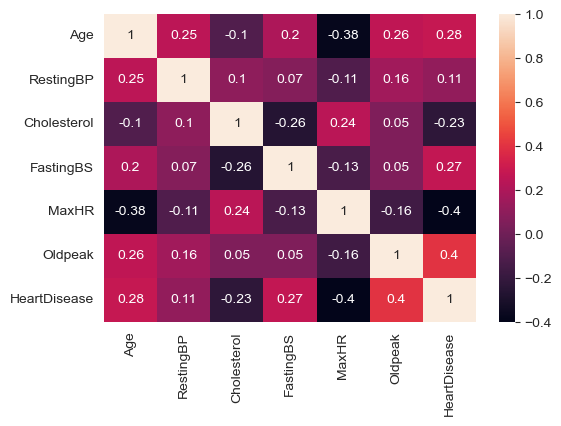

In [24]:
plt.figure(figsize = (6,4))
sns.heatmap(df_num.corr().round(2), annot = True)
plt.show()

# Continuous Exploration Results

> Every continous variable that we explored appears to have a strong relationship with the target variable.  The variables that we did not explore appear to be signficantly different based on the patient groupings.  Therefore, we will include all continous variables in our Machine Learning Algorithm

# Create Pipeline to prepare Data for ML Algorithm

In [25]:
df_num = df[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]
df_num.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')

In [26]:
df_cat = df[['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope']]
df_cat.columns

Index(['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [27]:
num_features = list(df_num.columns)
cat_features = list(df_cat.columns)

# full pipeline to transform data
full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_features), # scales data
    ('cat', OneHotEncoder(), cat_features) # gets dummy variables for categorical data
])

df_prepared = full_pipeline.fit_transform(df)
df_prepared[0]

array([-1.4331398 ,  0.41090889,  0.82507026, -0.55134134,  1.38292822,
       -0.83243239,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ])

# Machine Learning Models

In [29]:
# split dat
outcome = np.array(df.HeartDisease)

X_train, X_test, y_train, y_test = train_test_split(df_prepared, outcome, train_size = .8, random_state = 42)

# df to insert predictions into after training models
df_predictions = pd.DataFrame(data = y_test, columns = ['HeartDisease'])

# Neural Network

In [30]:
tf.random.set_seed(42)

# define model
model = Sequential(
    [
        Dense(units = 50, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(.05)),
        Dense(units = 25, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(.05)),
        Dense(units = 1, activation = 'linear', kernel_regularizer = tf.keras.regularizers.l2(.05))
    ]
)

# define loss function
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(0.01)
)

# fit model
history = model.fit(X_train, y_train, epochs = 1000, verbose = False, validation_split = 0.2)

# Check NN for Overfitting

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,0.537419,0.582374,995
996,0.538964,0.568178,996
997,0.540123,0.572417,997
998,0.541625,0.567200,998
999,0.541035,0.567923,999


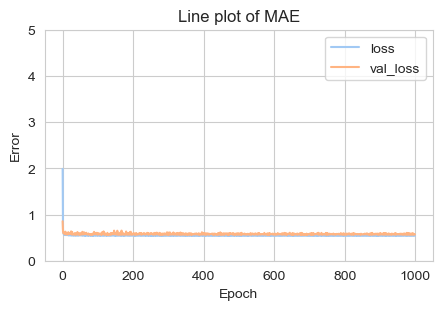

In [32]:
plt.figure(figsize = (5,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 5])

plt.title("Line plot of MAE")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [33]:
logit = model(X_test)
nn_predictions = tf.nn.sigmoid(logit)
nn_predictions[0:5] # preview predictions

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.10201477],
       [0.27698758],
       [0.9044523 ],
       [0.8911088 ],
       [0.12916222]], dtype=float32)>

In [35]:
df_predictions['NeuralNetProb'] = nn_predictions
df_predictions['NeuralNetPred'] = (df_predictions.NeuralNetProb >= .5).replace({False: 0, True: 1})

In [37]:
nn_accuracy = accuracy_score(df_predictions.HeartDisease, df_predictions.NeuralNetPred)
nn_precision = precision_score(df_predictions.HeartDisease, df_predictions.NeuralNetPred)
nn_recall = recall_score(df_predictions.HeartDisease, df_predictions.NeuralNetPred)

print(f"Neural Net Accuracy: {(nn_accuracy * 100):.2f}%")
print(f"Neural Net Precision: {(nn_precision * 100):.2f}%")
print(f"Neural Net Recall: {(nn_recall * 100):.2f}%")

Neural Net Accuracy: 85.33%
Neural Net Precision: 90.00%
Neural Net Recall: 84.11%


# Random Forest

In [38]:
rand_forest = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_split = 20)
rand_forest.fit(X_train, y_train)

rand_predictions = rand_forest.predict(X_test)

In [39]:
rand_accuracy = accuracy_score(df_predictions.HeartDisease, rand_predictions)
rand_precision = precision_score(df_predictions.HeartDisease, rand_predictions)
rand_recall = recall_score(df_predictions.HeartDisease, rand_predictions)

print(f"Random forest Accuracy: {(rand_accuracy * 100):.2f}%")
print(f"Random forestt Precision: {(rand_precision * 100):.2f}%")
print(f"Random forest Recall: {(rand_recall * 100):.2f}%")

Random forest Accuracy: 85.87%
Random forestt Precision: 88.57%
Random forest Recall: 86.92%


# XGBoost

In [40]:
xgb_forest = XGBClassifier(n_estimators = 200, max_depth = 5)
xgb_forest.fit(X_train, y_train)

xgb_predictions = xgb_forest.predict(X_test)

In [41]:
xgb_accuracy = accuracy_score(df_predictions.HeartDisease, xgb_predictions)
xgb_precision = precision_score(df_predictions.HeartDisease, xgb_predictions)
xgb_recall = recall_score(df_predictions.HeartDisease, xgb_predictions)

print(f"XGB forest Accuracy: {(xgb_accuracy * 100):.2f}%")
print(f"XGB forest Precision: {(xgb_precision * 100):.2f}%")
print(f"XGB forest Recall: {(xgb_recall * 100):.2f}%")

XGB forest Accuracy: 86.41%
XGB forestt Precision: 91.00%
XGB forest Recall: 85.05%


# Compare Models

In [44]:
accuracy_metrics = pd.DataFrame(data = [[nn_accuracy, nn_precision, nn_recall],
                                        [rand_accuracy, rand_precision, rand_recall],
                                        [xgb_accuracy, xgb_precision, xgb_recall]],
                                columns = ['Accuracy', 'Precision', 'Recall'],
                                index = ['Neural Net', 'Random Forest', 'XGB'])

accuracy_metrics = np.round(accuracy_metrics * 100, 2)
accuracy_metrics

,Accuracy,Precision,Recall
Neural Net,85.33,90.00,84.11
Random Forest,85.87,88.57,86.92
XGB,86.41,91.00,85.05
